In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

import itertools

from cpd_utils import *

import time
import bisect

import pandas as pd

from sklearn import linear_model
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
class dp_cv_random_covariate():
    """
    DP for data with response Y and covariate X

    """
    def __init__(self, grid_n, lam_list, gamma_list, smooth = 100, buffer = 200):
        self.grid_n = grid_n
        self.lam_list = lam_list
        self.gamma_list = gamma_list
        self.smooth = smooth
        self.buffer = buffer
        
    def estimate_func(self, y, X, lam):
        pass

    def loss_func(self, Y, X, beta):
        pass
 
    def goodness_of_fit(self, data_train, data_test, cp_loc, lam, gamma):
        '''
        currently the penalty is not included in the value of goodness-of-fit
        '''
        Y_train, X_train = data_train
        Y_test, X_test = data_test
        
        n = len(Y_train)
        p = X_train.shape[1]
        cp_loc = np.concatenate([[0], cp_loc, [n]])
        cp_loc = cp_loc.astype(int)
        res = 0
        for i in range(len(cp_loc) - 1):
            if cp_loc[i + 1] > cp_loc[i] + self.buffer + 1:
                Y_sub = Y_train[cp_loc[i]:cp_loc[i + 1]]
                X_sub = X_train[cp_loc[i]:cp_loc[i + 1]]
                estimate = self.estimate_func(Y_sub, X_sub, lam)
                
                Y_sub = Y_test[cp_loc[i]:cp_loc[i + 1]]
                X_sub = X_test[cp_loc[i]:cp_loc[i + 1]]
                res += self.loss_func(Y_sub, X_sub, estimate)
            else:
                res += 0
        return res
        
    def fit(self, data_train, data_test):
#         Y_train, X_train = data_train
#         Y_test, X_test = data_test

        lam_gamma_list = list(itertools.product(self.lam_list, self.gamma_list))
        n_grid = len(lam_gamma_list)
        fit_res_best = np.infty
        cp_best = None
        param_best = None
        for i, x in enumerate(lam_gamma_list):
            lam, gamma = x
            cp_loc, obj = self.dp_random(data_train, lam, gamma)
            fit_res = self.goodness_of_fit(data_train, data_test, cp_loc, lam, gamma)
            if fit_res < fit_res_best:
                cp_best = cp_loc
                param_best = x
                fit_res_best = fit_res
        return cp_best, param_best

    def dp_random(self, data_train, lam, gamma):
        Y_train, X_train = data_train
        n = len(Y_train)
        grid_n = min(self.grid_n, n - 1)
        
        grid = np.sort(np.random.choice(np.arange(1, n), grid_n, replace = False))
        cp_loc, fit_res = self.dp_grid(data_train, grid, lam, gamma)
            
        return cp_loc, fit_res


    def dp_grid(self, data, grid, lam, gamma):
        """
        data: (Y, X)
        Y: n x -1 array
        cp_loc: for each ix in cp_loc, it means theta[ix - 1] != theta[ix]
        """
        Y, X = data
        
        n = len(Y)
        point_map = np.ones(n + 1) * -1
        B = np.ones(n + 1) * np.infty
        B[0] = gamma

        r_cand = np.concatenate([[0], grid, [n]])
        grid_ix = {x:i for i, x in enumerate(r_cand)}
        l_cand = np.concatenate([[0], grid])
        m = len(grid)
        dp = [[np.infty] * (m + 2) for r in range(m + 1)]

        for r in r_cand:
            for l in l_cand:
                if l >= r - self.buffer:
                    break
                Y_sub = Y[l:r]
                X_sub = X[l:r]
                estimate = self.estimate_func(Y_sub, X_sub, lam)
                dp[grid_ix[l]][grid_ix[r]] = self.loss_func(Y_sub, X_sub, estimate)

        for r in r_cand:
            for l in l_cand:
                if l >= r - self.buffer:
                    break
                b = B[l] + gamma + dp[grid_ix[l]][grid_ix[r]]
                if b < B[r]:
                    B[r] = b
                    point_map[r] = l

        k = n
        cp_loc, cp_val = set([]), []
        while k > 0:
            h = int(point_map[k])
            if h > 0:
                cp_loc.add(h)
            k = h
        cp_loc = np.array(sorted(cp_loc))
        return cp_loc, B[-1]

    def dp_grid_test(self, data, grid, lam, gamma):
        """
        data: (Y, X)
        Y: n x -1 array
        cp_loc: for each ix in cp_loc, it means theta[ix - 1] != theta[ix]
        """
        Y, X = data
        
        n = len(Y)
        point_map = np.ones(n + 1) * -1
        B = np.ones(n + 1) * np.infty
        B[0] = gamma

        r_cand = np.concatenate([[0], grid, [n]])
        grid_ix = {x:i for i, x in enumerate(r_cand)}
        l_cand = np.concatenate([[0], grid])
        m = len(grid)
        dp = [[np.infty] * (m + 2) for r in range(m + 1)]

        for r in r_cand:
            for l in l_cand:
                if l >= r:
                    break
                Y_sub = Y[l:r]
                X_sub = X[l:r]
                estimate = self.estimate_func(Y_sub, X_sub, lam)
                dp[grid_ix[l]][grid_ix[r]] = self.loss_func(Y_sub, X_sub, estimate)

        for r in r_cand:
            for l in l_cand:
                if l >= r:
                    break
                b = B[l] + gamma + dp[grid_ix[l]][grid_ix[r]]
                if b < B[r]:
                    B[r] = b
                    point_map[r] = l

        k = n
        cp_loc, cp_val = set([]), []
        while k > 0:
            h = int(point_map[k])
            if h > 0:
                cp_loc.add(h)
            k = h
        cp_loc = np.array(sorted(cp_loc))
        return cp_loc, B, dp   
    
    
    
    
class dcdp_cv_random_covariate(dp_cv_random_covariate):
    def __init__(self, grid_n, lam_list, gamma_list, smooth = 100, 
                 buffer = 200, step_refine = 1, buffer_refine = 30, lam_refine = 0.1):
        self.grid_n = grid_n
        self.lam_list = lam_list
        self.gamma_list = gamma_list
        
        self.smooth = smooth
        self.buffer = buffer
        
        self.step_refine = step_refine
        self.buffer_refine = buffer_refine
        self.lam_refine = lam_refine

    def joint_estimate_func(self, Y1, X1, Y2, X2, lam):
        pass
        
    def estimate_func(self, y, X, lam):
        pass
    
    def loss_func(self, Y, X, beta):
        pass
 
    def goodness_of_fit(self, data_train, data_test, cp_loc, lam, gamma):
        Y_train, X_train = data_train
        Y_test, X_test = data_test
        
        n = len(Y_train)
        p = X_train.shape[1]
        cp_loc = np.concatenate([[0], cp_loc, [n]])
        cp_loc = cp_loc.astype(int)
        res = 0
        for i in range(len(cp_loc) - 1):
            if cp_loc[i + 1] > cp_loc[i] + np.log(p) + 1:
                Y_sub = Y_train[cp_loc[i]:cp_loc[i + 1]]
                X_sub = X_train[cp_loc[i]:cp_loc[i + 1]]
                estimate = self.estimate_func(Y_sub, X_sub, lam)
                
                Y_sub = Y_test[cp_loc[i]:cp_loc[i + 1]]
                X_sub = X_test[cp_loc[i]:cp_loc[i + 1]]
                res += self.loss_func(Y_sub, X_sub, estimate)
            else:
                Y_sub = Y_test[cp_loc[i]:cp_loc[i + 1]]
                res += np.sum(Y_sub**2)
        return res
        
    def fit(self, data_train, data_test):
        lam_gamma_list = list(itertools.product(self.lam_list, self.gamma_list))
        n_grid = len(lam_gamma_list)
        fit_res_best = np.infty
        cp_best = None
        param_best = None
        for i, x in enumerate(lam_gamma_list):
            lam, gamma = x
            cp_loc, obj = self.dp_random(data_train, lam, gamma)
            cp_loc_refined = self.local_refine(data_train, cp_loc)
            fit_res = self.goodness_of_fit(data_train, data_test, cp_loc_refined, lam, gamma)
            if fit_res < fit_res_best:
                cp_best = cp_loc_refined
                cp_best_cand = cp_loc
                param_best = x
                fit_res_best = fit_res
        return cp_best, param_best, cp_best_cand

    def local_refine(self, data, cp_cand):
        n = len(data[0])
        K = len(cp_cand)
        cp_cand = np.concatenate([[0], cp_cand[:], [n]])
        cp_loc = []
        for i in range(1, K + 1):
            if cp_cand[i - 1] + 2 * self.buffer_refine > cp_cand[i]:
                continue
            st, ed = int(2/3 * cp_cand[i - 1] + 1/3 * cp_cand[i]), int(2/3 * cp_cand[i + 1] + 1/3 * cp_cand[i])
            cp = self.screen_cp(data, st, ed)
            if cp is not None:
                cp_loc.append(cp)
        return cp_loc

    def screen_cp(self, data, st, ed):
        '''
        currently not using group lasso in refinement
        '''
        Y, X = data
        buffer_refine = self.buffer_refine
        step_refine = self.step_refine
        
        if st + 2 * buffer_refine + step_refine >= ed:
            return None
        n_step = (ed - st - 2 * buffer_refine - 1) // step_refine + 1

        loss_min = np.infty
        loc_min = None
        for i in range(1, n_step):
            loc = st + buffer_refine + int(i * step_refine)
            theta_1, theta_2 = self.joint_estimate_func(Y[st:loc],
                                                        X[st:loc],
                                                        Y[loc:ed],
                                                        X[loc:ed],self.lam_refine)
            loss_split = self.loss_func(Y[st:loc], 
                                        X[st:loc], theta_1)
            loss_split += self.loss_func(Y[loc:ed],
                                         X[loc:ed], theta_2)
            if loss_split < loss_min:
                loss_min = loss_split
                loc_min = st + buffer_refine + int(i * step_refine)
        return loc_min
    
    def local_refine_test(self, data, cp_cand):
        n = len(data[0])
        K = len(cp_cand)
        cp_cand = np.concatenate([[0], cp_cand[:], [n]])
        cp_loc = []
        for i in range(1, K + 1):
            if cp_cand[i - 1] + 2 * self.buffer_refine > cp_cand[i]:
                continue
            st, ed = int(2/3 * cp_cand[i - 1] + 1/3 * cp_cand[i]), int(2/3 * cp_cand[i + 1] + 1/3 * cp_cand[i])
            cp = self.screen_cp(data, st, ed)
            if cp is not None:
                cp_loc.append(cp)
        return cp_loc

    def screen_cp_test(self, data, st, ed):
        Y, X = data
        buffer_refine = self.buffer_refine
        step_refine = self.step_refine
        
        if st + 2 * buffer_refine + step_refine >= ed:
            return None
        n_step = (ed - st - 2 * buffer_refine - 1) // step_refine + 1

        loss_min = np.infty
        loc_min = None
        loss_list = []
        loc_list = []
        
        for i in range(1, n_step):
            loc = st + buffer_refine + int(i * step_refine)
            theta_1, theta_2 = self.joint_estimate_func(Y[st:loc],
                                                        X[st:loc],
                                                        Y[loc:ed],
                                                        X[loc:ed],self.lam_refine)
            loss_split = self.loss_func(Y[st:loc], 
                                        X[st:loc], theta_1)
            loss_split += self.loss_func(Y[loc:ed],
                                         X[loc:ed], theta_2)
            
            loss_list.append(loss_split)
            loc_list.append(loc)
            
            if loss_split < loss_min:
                loss_min = loss_split
                loc_min = st + buffer_refine + int(i * step_refine)
        return loc_min, loss_list, loc_list


class dp_cv_random_linear(dp_cv_random_covariate):
    def __init__(self, grid_n, lam_list, gamma_list, smooth = 100, buffer = 200):
        self.grid_n = grid_n
        self.lam_list = lam_list
        self.gamma_list = gamma_list
        self.smooth = smooth
        self.buffer = buffer
        
    def estimate_func(self, y, X, lam):
#         fit = lr_newton_solver_linear(X, y)

#         sm_model = sm.OLS(y, (X)).fit(disp=0)
#         beta_hat = sm_model.params

        lasso = linear_model.Lasso(alpha=lam, fit_intercept = False)
        lasso.fit(X, y)
        beta_hat = lasso.coef_
        return beta_hat.reshape((-1,1))

    def loss_func(self, Y, X, beta):
        '''
        currently the penalty is not included in the value of loss
        '''
        return np.sum((Y - X @ beta)**2)
    
    
class dcdp_cv_random_linear(dcdp_cv_random_covariate):
    def __init__(self, grid_n, lam_list, gamma_list, smooth = 100, 
                 buffer = 200, step_refine = 1, buffer_refine = 30, lam_refine = 0.1):
        self.grid_n = grid_n
        self.lam_list = lam_list
        self.gamma_list = gamma_list
        
        self.smooth = smooth
        self.buffer = buffer
        
        self.step_refine = step_refine
        self.buffer_refine = buffer_refine
        self.lam_refine = lam_refine

    def joint_estimate_func(self, Y1, X1, Y2, X2, lam):
        lasso = linear_model.Lasso(alpha=lam, fit_intercept = False)
        lasso.fit(X1, Y1)
        beta_hat1 = lasso.coef_
        
        lasso = linear_model.Lasso(alpha=lam, fit_intercept = False)
        lasso.fit(X2, Y2)
        beta_hat2 = lasso.coef_
        return beta_hat1.reshape((-1,1)), beta_hat2.reshape((-1,1))
        
    def estimate_func(self, y, X, lam):
#         fit = lr_newton_solver_linear(X, y)
        lasso = linear_model.Lasso(alpha=lam, fit_intercept = False)
        lasso.fit(X, y)
        beta_hat = lasso.coef_
        return beta_hat.reshape((-1,1))

    def loss_func(self, Y, X, beta):
        '''
        currently the penalty is not included in the value of loss
        '''
        return np.sum((Y - X @ beta)**2)

# DCDP

In [5]:
fred = pd.read_csv('FRED.csv')

In [6]:
fred = fred.dropna(axis = "columns")

In [7]:
fred

,date,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,...,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,INVEST,VIXCLSx
0,2000-01-01,-0.002434,0.007932,-0.006763,-0.000592,-0.002811,-0.004488,-0.013108,0.017841,-0.025743,...,0.000602,0.000409,0.003036,-0.004309,0.000655,-0.001185,1.403784e-03,6.6,-0.009868,24.8430
1,2000-02-01,0.009364,-0.018159,0.014724,0.003666,0.005090,0.006240,0.007465,-0.003394,0.012017,...,0.000596,0.000406,-0.002375,0.005047,-0.000680,0.002320,-4.258847e-03,-0.7,-0.008760,25.4560
2,2000-03-01,0.004919,0.011754,0.011593,0.003790,0.002175,0.001130,-0.003713,-0.003371,-0.003805,...,0.002998,0.001161,0.004718,0.005466,-0.000673,-0.000606,1.411929e-03,-4.2,0.016952,24.7678
3,2000-04-01,-0.000295,0.008276,-0.015180,0.006214,0.008025,0.008056,0.008362,0.012836,0.006569,...,-0.007840,-0.005128,-0.003452,-0.016760,0.001973,0.001705,2.105965e-03,2.1,-0.004814,29.8331
4,2000-05-01,0.003732,-0.005321,0.001283,0.002954,0.001604,0.003450,0.001816,-0.003625,0.004059,...,0.003008,0.001673,0.001615,0.002298,-0.004625,-0.006921,-4.928346e-03,1.5,-0.002408,29.4290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2019-08-01,0.002841,0.005454,0.004785,0.006898,0.004824,0.004907,0.003430,0.010295,0.001465,...,-0.001365,-0.000864,0.004229,-0.003983,0.002824,0.005265,-1.806682e-03,-8.6,0.004553,19.4147
236,2019-09-01,0.001213,-0.001285,-0.006551,-0.003208,-0.006525,-0.008930,-0.007521,-0.019210,-0.004113,...,0.000911,0.000208,0.001978,0.001179,-0.000816,-0.001067,-8.108921e-07,3.4,0.005980,15.7324
237,2019-10-01,0.000585,-0.006168,0.003401,-0.007844,-0.004047,-0.003160,-0.002462,-0.033859,0.006454,...,0.000703,0.001648,-0.000894,0.005826,-0.000409,-0.003146,2.243860e-03,2.3,-0.017894,15.0714
238,2019-11-01,0.003286,0.004031,0.004331,0.003143,0.008942,0.012285,0.013186,0.058925,0.000080,...,-0.000464,-0.001587,-0.002434,-0.002519,-0.001206,0.001742,4.370739e-04,1.3,0.006901,12.3952


In [8]:
fred.shape

(240, 114)

In [9]:
nt = len(fred)
Y = fred.loc[:, "INDPRO"].values
X = fred.drop(["date", "INDPRO"], axis = 1).values

Y_train = Y[np.arange(0, nt, 2)]
Y_test = Y[np.arange(1, nt, 2)]
X_train = X[np.arange(0, nt, 2), :]
X_test = X[np.arange(1, nt, 2), :]

In [29]:
X.shape

(240, 112)

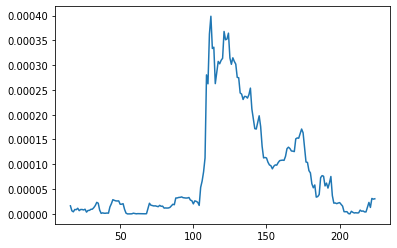

In [42]:
eda = cpd_eda_linear()
path_t_all, path_loglike_all = eda.draw_glr_path(X, Y, smooth = 16, step = 1)
plt.plot(path_t_all, path_loglike_all)
# plt.savefig('nba_glr_all_2.pdf', bbox_inches='tight')

In [43]:
ix = np.argmax(path_loglike_all)
fred["date"].values[path_t_all[ix]]

'2009-05-01'

In [44]:
fred["date"].values[110]

'2009-03-01'

In [13]:
fred["date"].values[170]

'2014-03-01'

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

std = np.std(Y_train)
mu = np.mean(Y_train)
Y_train = (Y_train - mu) / std
Y_test = (Y_test - mu) / std

In [24]:
print(Y_train.shape)
print(X_train.shape)

(120,)
(120, 112)


(array([ 1.,  0.,  0.,  1.,  2.,  2., 17., 50., 39.,  8.]),
 array([-6.24698095, -5.43252411, -4.61806727, -3.80361043, -2.9891536 ,
        -2.17469676, -1.36023992, -0.54578308,  0.26867376,  1.08313059,
         1.89758743]),
 <a list of 10 Patch objects>)

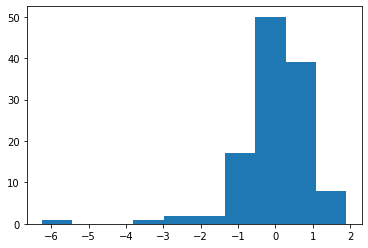

In [25]:
plt.hist(Y_train)

In [ ]:
# import matplotlib.gridspec as gridspec

# Y = djia.iloc[:, np.arange(29)].values
# n = Y.shape[0]
# p = Y.shape[1]
# ix = np.arange(n)

# y_max = Y.max(axis = (0,1))
# y_min = Y.min(axis = (0,1))

# gs = gridspec.GridSpec(p, 1)
# fig = plt.figure(figsize = (10, 20))

# for i in range(p - 1):
#     ax = fig.add_subplot(gs[i])
#     ax.plot(ix, Y[:, i])
#     plt.ylim([y_min, y_max])
#     ax.set_ylabel(str(i), size =16)
# #     ax.get_yaxis().set_label_coords(y_min, y_max)
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         labelbottom='off') # labels along the bottom edge are off

# # the last plot
# ax = fig.add_subplot(gs[p - 1], sharex = ax)
# ax.plot(ix, Y[:, p - 1])
# ax.set_ylabel(str(p - 1), size =16)
# # ax.get_yaxis().set_label_coords(y_min, y_max)
# plt.ylim([y_min, y_max])
# x = ax.get_xticks().tolist()
# for i, v in enumerate(x):
#     if v < n:
#         x[i] = djia['time'].values[int(v)]
# ax.set_xticklabels(x)

# plt.show()

In [11]:
np.sum(fred.isna().values, axis = (0, 1))

0

In [30]:
np.std(Y_train)

1.0

In [74]:
grid_n = 200
gamma_list = [400, 600, 800]
# gamma_list = [0.075, 0.1, 0.5]
lam_list = [0.1, 1, 5, 10]

run_time_dc  = 0
loc_error_dc = 0

print('---------- divide and conquer -----------')
start_time = time.time()
dcdp = dcdp_cv_random_linear(grid_n, lam_list, gamma_list, smooth = 10,
             buffer = 10, step_refine = 1, buffer_refine = 10, lam_refine = 1)
cp_best, param_best, cp_best_cand = dcdp.fit((Y_train, X_train), (Y_test, X_test))
# loc_error_dc = cp_distance(cp_best, cp_truth)
run_time_dc = time.time() - start_time

print("time: {0}".format(run_time_dc))
print("best parameter: {0}".format(param_best))

---------- divide and conquer -----------
time: 32.52417612075806
best parameter: (5, 400)


In [75]:
print("time: {0}".format(run_time_dc))
print("best parameter: {0}".format(param_best))

time: 32.52417612075806
best parameter: (5, 400)


In [76]:
print(cp_best)
print(cp_best_cand)

[27, 48, 91]
[27 52 63 91]


In [77]:
for cp in cp_best:
    print(fred["date"].values[2 * cp])

2004-07-01
2008-01-01
2015-03-01


In [26]:
grid_n = 200
gamma_list = [800, 1000]
# gamma_list = [0.075, 0.1, 0.5]
lam_list = [0.1, 1, 5, 10]

run_time_dc  = 0
loc_error_dc = 0

np.random.seed(0)
print('---------- divide and conquer -----------')
start_time = time.time()
dcdp = dcdp_cv_random_linear(grid_n, lam_list, gamma_list, smooth = 10,
             buffer = 10, step_refine = 1, buffer_refine = 10, lam_refine = 1)
cp_best, param_best, cp_best_cand = dcdp.fit((Y_train, X_train), (Y_test, X_test))
# loc_error_dc = cp_distance(cp_best, cp_truth)
run_time_dc = time.time() - start_time

print("time: {0}".format(run_time_dc))
print("best parameter: {0}".format(param_best))

---------- divide and conquer -----------
time: 24.958641529083252
best parameter: (5, 800)


In [27]:
print(cp_best)
print(cp_best_cand)

[44, 87]
[52 57 86]


In [28]:
for cp in cp_best:
    print(fred["date"].values[2 * cp])

2007-05-01
2014-07-01


In [31]:
grid_n = 200
gamma_list = [1500,2000]
# gamma_list = [0.075, 0.1, 0.5]
lam_list = [1, 5, 10]

run_time_dc  = 0
loc_error_dc = 0

np.random.seed(0)
print('---------- divide and conquer -----------')
start_time = time.time()
dcdp = dcdp_cv_random_linear(grid_n, lam_list, gamma_list, smooth = 10,
             buffer = 10, step_refine = 1, buffer_refine = 10, lam_refine = 1)
cp_best, param_best, cp_best_cand = dcdp.fit((Y_train, X_train), (Y_test, X_test))
# loc_error_dc = cp_distance(cp_best, cp_truth)
run_time_dc = time.time() - start_time

print("time: {0}".format(run_time_dc))
print("best parameter: {0}".format(param_best))

---------- divide and conquer -----------
time: 24.80376672744751
best parameter: (5, 1500)


In [32]:
print(cp_best)
print(cp_best_cand)

[48]
[52 63]


In [33]:
for cp in cp_best:
    print(fred["date"].values[2 * cp])

2008-01-01


(0, 0.0003988108661906499)

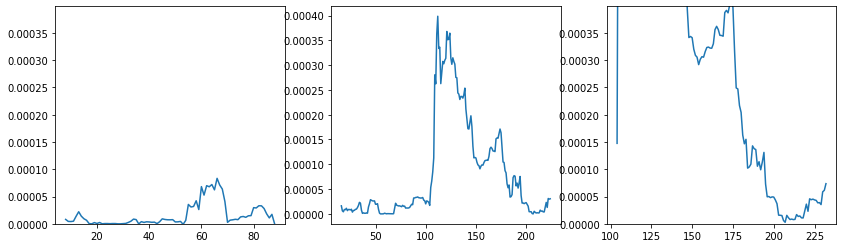

In [52]:
cp_ = 2 * cp_best[0]


eda = cpd_eda_linear()
fig, ax = plt.subplots(figsize = (14, 4), nrows = 1, ncols = 3)

path_t_all, path_loglike_all = eda.draw_glr_path(X, Y, smooth = 16, step = 1)
ax[1].plot(path_t_all, path_loglike_all)
y_max = np.max(path_loglike_all)

path_t_all, path_loglike_all = eda.draw_glr_path(X[0:cp_,:], Y[0:cp_], smooth = 8, step = 1)
ax[0].plot(path_t_all, path_loglike_all)
ax[0].set_ylim([0, y_max])
# plt.savefig('nba_glr_all_2.pdf', bbox_inches='tight')

path_t_all, path_loglike_all = eda.draw_glr_path(X[cp_:,:], Y[cp_:], smooth = 8, step = 1)
ax[2].plot(path_t_all + cp_, path_loglike_all)
ax[2].set_ylim([0, y_max])

In [37]:
fred["date"].values[65]

'2005-06-01'

(0, 0.0003988108661906499)

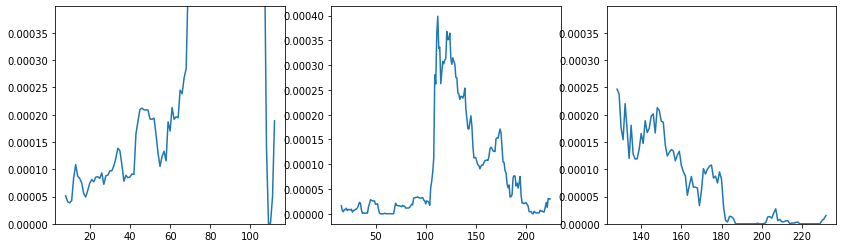

In [51]:
cp_ = 120


eda = cpd_eda_linear()
fig, ax = plt.subplots(figsize = (14, 4), nrows = 1, ncols = 3)

path_t_all, path_loglike_all = eda.draw_glr_path(X, Y, smooth = 16, step = 1)
ax[1].plot(path_t_all, path_loglike_all)
y_max = np.max(path_loglike_all)

path_t_all, path_loglike_all = eda.draw_glr_path(X[0:cp_,:], Y[0:cp_], smooth = 8, step = 1)
ax[0].plot(path_t_all, path_loglike_all)
ax[0].set_ylim([0, y_max])
# plt.savefig('nba_glr_all_2.pdf', bbox_inches='tight')

path_t_all, path_loglike_all = eda.draw_glr_path(X[cp_:,:], Y[cp_:], smooth = 8, step = 1)
ax[2].plot(path_t_all + cp_, path_loglike_all)
ax[2].set_ylim([0, y_max])

(0, 0.0003988108661906499)

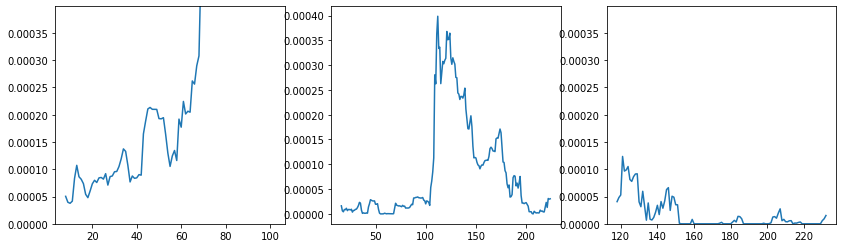

In [53]:
cp_ = 110


eda = cpd_eda_linear()
fig, ax = plt.subplots(figsize = (14, 4), nrows = 1, ncols = 3)

path_t_all, path_loglike_all = eda.draw_glr_path(X, Y, smooth = 16, step = 1)
ax[1].plot(path_t_all, path_loglike_all)
y_max = np.max(path_loglike_all)

path_t_all, path_loglike_all = eda.draw_glr_path(X[0:cp_,:], Y[0:cp_], smooth = 8, step = 1)
ax[0].plot(path_t_all, path_loglike_all)
ax[0].set_ylim([0, y_max])
# plt.savefig('nba_glr_all_2.pdf', bbox_inches='tight')

path_t_all, path_loglike_all = eda.draw_glr_path(X[cp_:,:], Y[cp_:], smooth = 8, step = 1)
ax[2].plot(path_t_all + cp_, path_loglike_all)
ax[2].set_ylim([0, y_max])

In [ ]:
cp = np.concatenate([[0], cp_best_cand[:], [len(Y_train)]])
beta_path = dcdp.fit_with_cp(Y_train, cp)

In [ ]:
print(beta_path)
print(theta)